这里Wide模型和Deep模型实现多输出，多输出主要针对多任务问题，而不是Wide&Deep模型所需要的

例如房价问题中不仅需要预测当前房价，还需要预测一年后的房价，需要给出两个输出结果

需要修改构建模型结构和模型输出数据部分

In [1]:
# 使用tf.keras搭建回归模型，数据集使用加利福尼亚的房价预测
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# 导入数据
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
# 打印数据
import pprint

pprint.pprint(housing.data[:5])
pprint.pprint(housing.target[:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
# 拆分训练集、测试集、验证集
from sklearn.model_selection import train_test_split

# 默认按3：1的比例拆分
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 数据归一化

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 训练机上获得均值和方差，测试集和验证集上用相同的均值和方差
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 构建模型

In [6]:
# 多输入,前5个特征作为wide模型的输入，后6个特征作为deep模型的输入,定义模型 
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
# 在hidden2后面添加第二个输出结果
output2 = keras.layers.Dense(1)(hidden2)
# 修改输出数据
model = keras.models.Model(inputs = [input_wide, input_deep], outputs=[output, output2])

In [7]:

model.summary()
# 编译，目标函数使用均方差，优化方法使用随机梯度下降，也可以自己定义
model.compile(loss='mean_squared_error', optimizer='sgd')#(learning_rate=0.001)
# 使用earlystopping
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [8]:
# 输入数据也需要重新定义
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

history = model.fit([x_train_scaled_wide, x_train_scaled_deep]
                    , [y_train, y_train],
                   validation_data = (
                       [x_valid_scaled_wide, x_valid_scaled_deep]
                       , [y_valid, y_valid]),
                   epochs=100, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 50us/sample - loss: 2.0131 - dense_2_loss: 0.8265 - dense_3_loss: 1.1861 - val_loss: 1.1634 - val_dense_2_loss: 0.5133 - val_dense_3_loss: 0.6505
Epoch 2/100
11610/11610 [==============================] - 0s 34us/sample - loss: 1.0564 - dense_2_loss: 0.4730 - dense_3_loss: 0.5831 - val_loss: 1.0519 - val_dense_2_loss: 0.4522 - val_dense_3_loss: 0.5997
Epoch 3/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.9625 - dense_2_loss: 0.4176 - dense_3_loss: 0.5450 - val_loss: 0.9928 - val_dense_2_loss: 0.4268 - val_dense_3_loss: 0.5660
Epoch 4/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.9164 - dense_2_loss: 0.4026 - dense_3_loss: 0.5139 - val_loss: 0.9494 - val_dense_2_loss: 0.4111 - val_dense_3_loss: 0.5381
Epoch 5/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.8731 - dense_2_loss: 0.3846 - dense

11610/11610 [==============================] - 0s 30us/sample - loss: 0.6611 - dense_2_loss: 0.3045 - dense_3_loss: 0.3567 - val_loss: 0.6880 - val_dense_2_loss: 0.3182 - val_dense_3_loss: 0.3700
Epoch 41/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6598 - dense_2_loss: 0.3035 - dense_3_loss: 0.3565 - val_loss: 0.7222 - val_dense_2_loss: 0.3301 - val_dense_3_loss: 0.3919


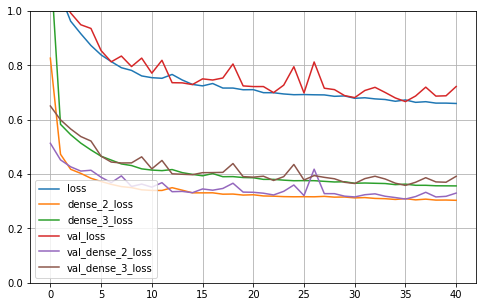

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [10]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], [y_test, y_test])

5160/5160 [==============================] - 0s 20us/sample - loss: 0.7252 - dense_2_loss: 0.3360 - dense_3_loss: 0.3900


[0.7251813641814299, 0.33598536, 0.39002928]

前两个值为后两个值的和